In [1]:
!pip install tensorflow opencv-python matplotlib


In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:


# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)



In [7]:
!apt-get install p7zip-full -y
!7z x lfw.zip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 47185920 bytes (45 MiB)

Extracting archive: lfw.zip
  3% 256 Open             
ERRORS:
Unexpected end of archive

--
Path = lfw.zip
Type = zip
ERRORS:
Unexpected end of archive
Physical Size = 47185920

 98%     20% 1608          41% 3244 - lfw/Amram_Mitzna/Amram_Mitzna_0001.jpg                                                   63% 4943       

In [8]:
!7z x smtg.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 15806911 bytes (16 MiB)

Extracting archive: smtg.zip
--
Path = smtg.zip
Type = zip
Physical Size = 15806911

  0%     42% 387 - smtg/first/bf8e7453-ef95-11ef-8d6e-c85acf6a2454.jpg                                                               77% 706 - smtg/second/ca1fa682-ef98-11ef-9319-c85acf6a2454.jpg                                                               Everything is Ok

Folders: 3
Files: 900
Size:       15717232
Compressed: 15806911


In [9]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [10]:
# Import uuid library to generate unique image names
import uuid

In [11]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/1a8841e8-efac-11ef-9f49-0242ac1c000c.jpg'

In [12]:
import os
import shutil

# Define source and destination directories
source_anc = "/content/smtg/first"
source_pos = "/content/smtg/second"

# Move images from '/content/smtg/first' to ANC_PATH
for file_name in os.listdir(source_anc):
    src_path = os.path.join(source_anc, file_name)
    dst_path = os.path.join(ANC_PATH, file_name)
    shutil.move(src_path, dst_path)

# Move images from '/content/smtg/second' to POS_PATH
for file_name in os.listdir(source_pos):
    src_path = os.path.join(source_pos, file_name)
    dst_path = os.path.join(POS_PATH, file_name)
    shutil.move(src_path, dst_path)

print("Images moved successfully!")


Images moved successfully!


In [14]:
import tensorflow as tf

# Use forward slashes instead of backslashes
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(300)


In [15]:
dir_test = anchor.as_numpy_iterator()

In [16]:
print(dir_test.next())

b'data/anchor/f8cb42fe-ef95-11ef-867b-c85acf6a2454.jpg'


In [17]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img


In [18]:
img = preprocess('data/anchor/f8cb42fe-ef95-11ef-867b-c85acf6a2454.jpg')

In [19]:
img.numpy().max()

0.9017157

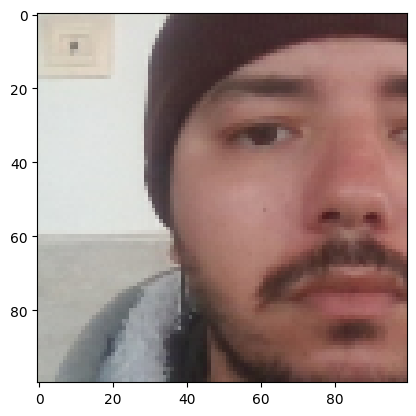

In [20]:
plt.imshow(img)

In [21]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [22]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [23]:
samples = data.as_numpy_iterator()

In [24]:
exampple = samples.next()

In [25]:
exampple

(b'data/anchor/930de76e-ef98-11ef-b5d4-c85acf6a2454.jpg',
 b'data/positive/d5890c01-ef98-11ef-9dbd-c85acf6a2454.jpg',
 1.0)

In [26]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [27]:
res = preprocess_twin(*exampple)

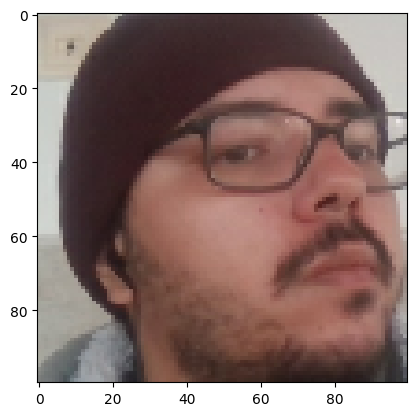

In [28]:
plt.imshow(res[1])

In [29]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)


In [30]:


# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)



In [31]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)


In [32]:
inp = Input(shape=(100,100,3), name='input_image')

In [33]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [34]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [35]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [36]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)


In [37]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)


In [38]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [39]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [41]:
embedding = make_embedding()

In [42]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [46]:
l1 = L1Dist()

NameError: name 'anchor_embedding' is not defined